Please copy this file into your own directory before editing. Then replace my name and ID with your own here at the top. When you save your final results, be sure to save the results that you generate in the cells.

Sai Chandana Vallam Kondu, 023810339

#Deep Convolutional Generative Adversarial Networks (DCGAN)
Goals
In this notebook, you will work with a deep convolutional GAN model developed in 2015 ([DCGAN](https://arxiv.org/pdf/1511.06434v1.pdf); Radford, Metz, Chintala, ICLR, 2016). The GAN will learn how to counterfeit the images in the fashionMNIST data set.

For more advanced Python students, you may try to use the CIFAR10 data instead. You will need to change the input parameter sizes to account for the three color channels.

**Learning Objectives**

*   Get hands-on experience making a Deep Convolutional GAN (DCGAN)
*   Train a powerful generative model.


Structure:
1.  Set up dependencies
2.  ***Complete the Code*** Build DCGAN Generator Model using PyTorch (explain the model structure for the generator and the discriminator)
3.  ***Complete the Code*** Build DCGAN Discriminator Model using PyTorch (explain the model structure for the generator and the discriminator)
4.  Set the model parameters.
5.  Run and train the model

## 1 Import Packages and Image Visualization Code

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


## 2 Generator Structure
The first component you will make is the generator. You will pass the number of image channels to determine the size of the filters.
The generator will have 4 layers (3 hidden layers + 1 output layer). You will need to write a function to create a single block for the generator's neural network.

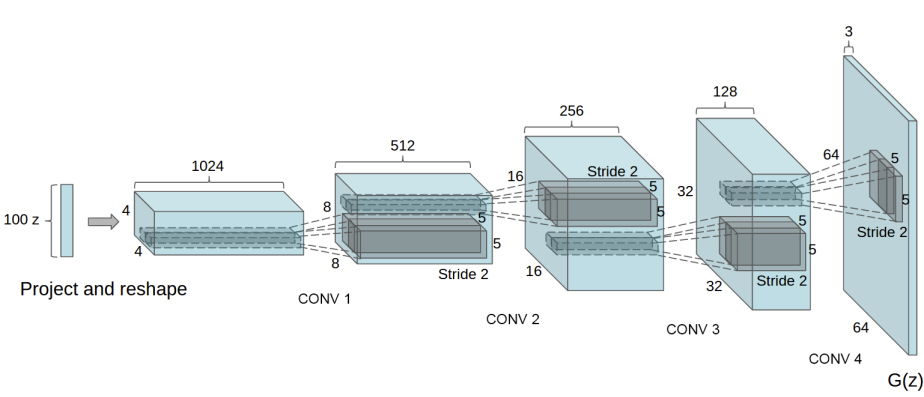

In DCGANs, the activation function will be different for the output layer. Thus, you will need to check what layer is being created. You are supplied with some tests following the code cell so you can see if you're on the right track!
At the end of the generator class, you are given a forward pass function that takes in a noise vector and generates an fake image at the output dimension using your neural network. You are also given a function to create a noise vector. You will use nn.ConvTranspose2d, nn.BatchNorm2d, nn.ReLU and nn.Tanh.

###2.1 Generator Model


In [ ]:
# GRADED FUNCTION: Generator
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network by calling the generator block four times
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation (ReLU or leakyrelu).
        For the final layer, use a transposed convolution and a tanh output.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean variable, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.
        if not final_layer:
            return nn.Sequential( # generator block
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
                #### END CODE HERE ####
            )
        else: # Final layer
            return nn.Sequential(
                #### START CODE HERE ####
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
                #### END CODE HERE ####
            )
    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)


Now, generate the input noise vectors, z, for the generator from a normal distribution.

In [ ]:

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

Test the generator function.

In [ ]:
gen = Generator() # Instantiate the generator block
num_test = 100

# Test the hidden block dimensions
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

In [ ]:
# Run UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


##3  Set up Discriminator or Critic Model
The second component you need to create is the discriminator.
You will use 3 layers in your discriminator's neural network. Like with the generator, you will need create the function to create a single neural network block for the discriminator. The output of the discriminator is a sigmoid function where 1 means the image is real and 0 is that it is fake.

You'll find nn.Conv2d, nn.BatchNorm2d, nn.LeakyReLU, and nn.Sigmoid useful!

###3.2 Discriminator or Critic


In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the final layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2
        #.         and set inplace = True.

        if not final_layer:
            return nn.Sequential(
                #### START CODE HERE ####
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.18)
                #### END CODE HERE ####
            )
        else: # Final Layer, note that the output is just the convolution, no activation function
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid()
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

The code below will test your network to make sure that everything is the right size and is making sense.

In [ ]:
# Discriminator unit test
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)
print(final_output.max())

# Test the whole thing:
disc_output = disc(test_images)
print(disc_output.std())
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() < 1.001
assert final_output.min() > -0.001
assert final_output.std() > 0.1
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.0
assert disc_output.std() < 0.2
print("Success!")

tensor(0.8268, grad_fn=<MaxBackward1>)
tensor(0.0681, grad_fn=<StdBackward0>)
Success!


##4 Training Parameters

Now you can put it all together! Remember that these are your parameters:

- n_epochs: the number of times you iterate through the entire dataset when training
- z_dim: the dimension of the noise vector
- display_step: how often to display/visualize the images
- batch_size: the number of images per forward/backward pass
- lr: the learning rate
- beta_1, beta_2: the momentum term for ADAM initialization
- device: the device type


In [ ]:
n_epochs = 50

z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

# These parameters control the optimizer's momentum
beta_1 = 0.5
beta_2 = 0.999

device = 'cuda'

# Tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    FashionMNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12714441.28it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202672.98it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3755155.41it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6197553.67it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



###4.1 initialize your generator, discriminator, and optimizers.
Next, we define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of *D*
 and *G*. This is also the convention used in the original GAN paper. Finally, we set up two separate optimizers, one for *D*
 and one for *G*. As specified in the DCGAN paper, both are Adam optimizers with learning rate 0.0002 and Beta1 = 0.5.


In [ ]:
criterion = nn.BCELoss()
#Use nn.BCEWithLogitsLoss() if you omit the sigmoid at the output of the discriminator.

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

##5 Initialize and Run the Model

Finally, you can train your GAN! For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. **Be sure to set the Runtime type to GPU so that it will run quickly!**

Here's roughly the progression you should be expecting. On GPU this takes about 30 seconds per thousand steps. On CPU, this can take about 8 hours per thousand steps. You might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones or another number. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator may just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse


###5.1 Initialize the model parameters

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_losses = []
disc_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader): #use tqdm(dataloader) to get a progress bar
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad() # Zero out gradients
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise) # generate fake images from noise input

        disc_fake_pred = disc(fake.detach()) # use discriminator to judge images
        # NOTE: the detach function holds the generator constant when we update the disc
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        # Judge real images and compute loss
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        # combine losses
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update discriminator weights using optimizer
        disc_opt.step()
        disc_losses += [disc_loss.item()]

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        #mean_generator_loss += gen_loss.item() / display_step
        gen_losses += [gen_loss.item()]

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(gen_losses[-display_step:]) / display_step
            disc_mean = sum(disc_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(gen_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1



Output hidden; open in https://colab.research.google.com to view.

##6 Questions
1. Describe the basic GAN training process of the generator and the discriminator in your own words. You can turn in a separate document with a scanned image.
**Answer:**

A Generative Adversarial Network (GAN) consists of two neural networks, the Generator (G) and the Discriminator (D), which are trained simultaneously through adversarial processes.

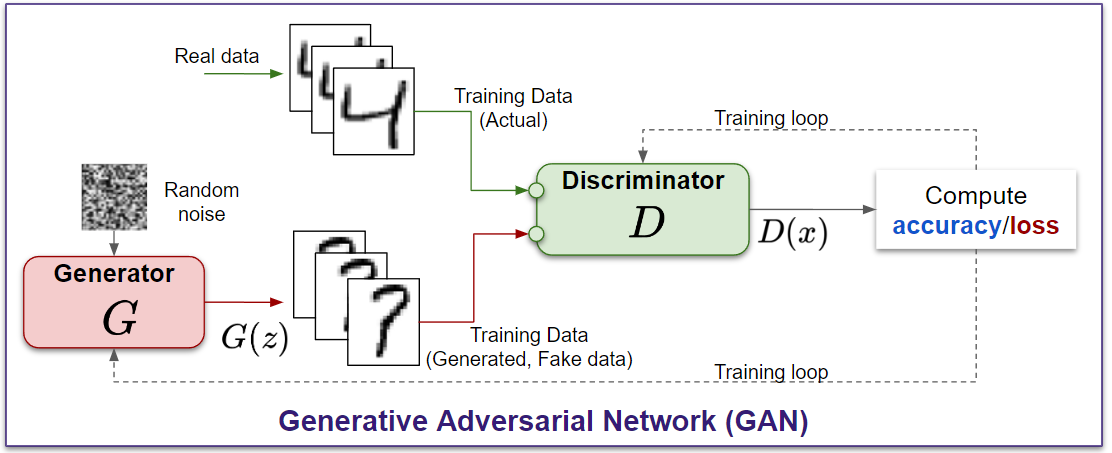

## Generator (G):
- The Generator's goal is to produce data that is indistinguishable from genuine data. It learns to map from a latent space $Z$ (a source of noise) to the data space $X$ (e.g., images).
- Mathematically, if $z$ is a point in the latent space, the Generator creates a data point $G(z)$.

## Discriminator (D):
- The Discriminator's objective is to distinguish between actual data and the data produced by the Generator.
- It outputs a probability $D(x)$, representing the likelihood that $x$ is a real data point rather than a fake one produced by G.

## Training Process:
- The training involves a min-max game where the Generator tries to maximize the probability of the Discriminator making a mistake, while the Discriminator tries to minimize this probability.
- The value function $V(G, D)$ for this game is given by the following equation:

$$ \min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))] $$

- Here, $\mathbb{E}_{x \sim p_{data}(x)}[\log D(x)]$ is the expected log probability that the real data $x$ is recognized as real by D.
- $\mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$ is the expected log probability that a fake instance $G(z)$ is recognized as fake.

## Learning Dynamics:
- **For the Discriminator:** In each training step, it improves its ability to distinguish real data from fakes. This is akin to increasing its accuracy in classifying data as real or generated.
- **For the Generator:** It updates its parameters to produce data that are more likely to be classified as real by the Discriminator. This is achieved by adjusting its parameters to increase $\log(1 - D(G(z)))$.

## Equilibrium:
- The training continues until a point of equilibrium is reached where the Generator produces perfectly realistic data, and the Discriminator is unable to distinguish real data from fake, essentially guessing at random (i.e., $D(x) = 0.5$ for all $x$).




---



2. Include your outputs in the saved notebook and comment on how many steps it took have "good" fakes of the numbers. Which numbers were copied well and which ones were poor? Did you see any "mode collapse" while training? It happens on some runs.
**Answer:**
- At Final Step 23000: Generator loss: 0.7814681004285813, discriminator loss: 0.6702136251926422. So, the model has taken 23,000 steps for "good" fakes of the numbers.
- 75-150 were well copied. 0-50 were poor.
- No, I did not notice any "mode collapse."



---

3. Change the zdim (the size of the input noise vector) or try with a different data set to see how the generator works. Comment on your result.
**Answer:**
- Changed z_dim, noise vector, to 128. The results were computed again in the follwoing code cell. At Final Step 23000: Generator loss: 0.8551191101074219, discriminator loss: 0.6443710856437683

- I've noticed that the clarity of images generated with a z_dim = 64 is better compared to those with a z_dim = 128. On the other hand, the variety of images available at a z_dim = 128 is greater than at z_dim = 64.

In [ ]:
z_dim = 128

# --------

criterion = nn.BCELoss()
#Use nn.BCEWithLogitsLoss() if you omit the sigmoid at the output of the discriminator.

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

# --------
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_losses = []
disc_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader): #use tqdm(dataloader) to get a progress bar
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad() # Zero out gradients
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise) # generate fake images from noise input

        disc_fake_pred = disc(fake.detach()) # use discriminator to judge images
        # NOTE: the detach function holds the generator constant when we update the disc
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        # Judge real images and compute loss
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        # combine losses
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update discriminator weights using optimizer
        disc_opt.step()
        disc_losses += [disc_loss.item()]

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        #mean_generator_loss += gen_loss.item() / display_step
        gen_losses += [gen_loss.item()]

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(gen_losses[-display_step:]) / display_step
            disc_mean = sum(disc_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(gen_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1
# --------

Output hidden; open in https://colab.research.google.com to view.

## References
1. Coursera Introduction to GANs course, labs 2 and 3.

2. [DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) tutorial at PyTorch.org which uses the [Celeb-A Faces](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. This uses a similar structure as this example, but you can see how to deal with multiple image channels. The code is very well commented as well. Here is an example result from this site:
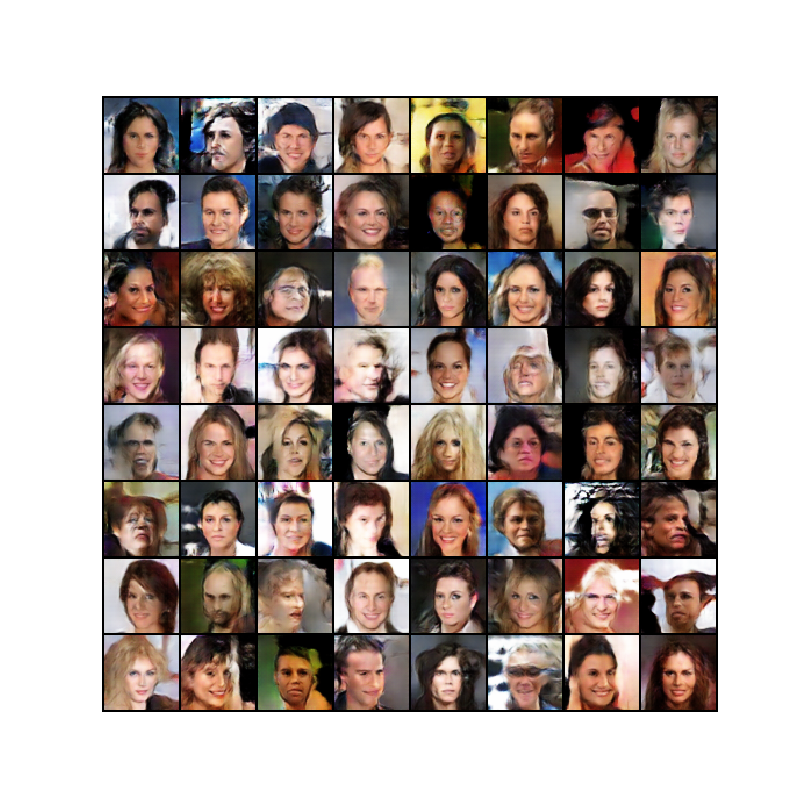
3. UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL
GENERATIVE ADVERSARIAL NETWORKS; Radford, Metz, Chintala, ICLR, 2016 [DCGAN Paper](https://arxiv.org/pdf/1511.06434v1.pdf)